In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from sklearn.datasets import load_digits
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from typing import NewType

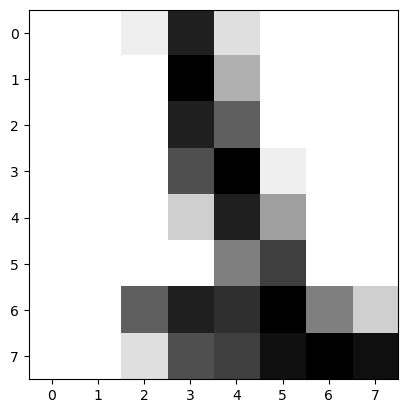

In [3]:
digits = load_digits(as_frame=True)
image_ = digits.data.iloc[1000].to_numpy().reshape(8, 8)
plt.imshow(image_, cmap='gray_r')

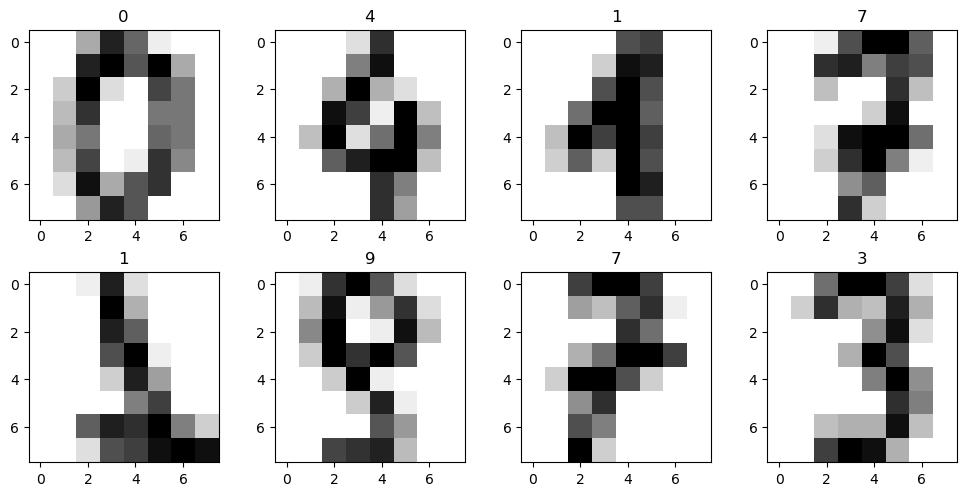

In [4]:
def reshape_image(row: int, df: pd.DataFrame)-> np.array:
    return df.iloc[row].to_numpy().reshape(8, 8)

rows = [0,100,200, 300, 1000, 1100, 1200, 1300]

images_reshaped = [reshape_image(row, digits.data) for row in rows]


Plot = NewType('Plot', plt.plot)

def plot_digits(images:np.array, row)-> Plot:
    
    fig_kw = {"tight_layout": True}
    
    grid_shape = int(len(images)/2)
    
    fig, ax = plt.subplots(nrows= 2, ncols = grid_shape, figsize = (10,5), **fig_kw)
    
    for image, ax, row in zip(images, ax.flatten(), rows):
        ax.imshow(image, cmap='gray_r')
        ax.set_title(digits.target[row])
        
    plt.show()
    
plot_digits(images_reshaped, rows)
                          



## Cross-validation of KNeighborsClassifier using K-fold range from 2-100

In [6]:


def xval_knn(data = digits.frame, features = digits.feature_names, 
                     target = 'target', k_fold = 5):
    
    kf = KFold(n_splits = k_fold, shuffle= True)
    
    all_acc = list()
    for train_index, test_index in kf.split(data):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        knc = KNeighborsClassifier().fit(train[features], train[target])
        prediction = knc.predict(test[features])
        acc_score = accuracy_score(test[target], prediction)
        all_acc.append(acc_score)
    return np.mean(all_acc)
    
    
   
k_vals = range(2,100,10)
acc_scores = [xval_knn(k_fold = k) for k in k_vals]


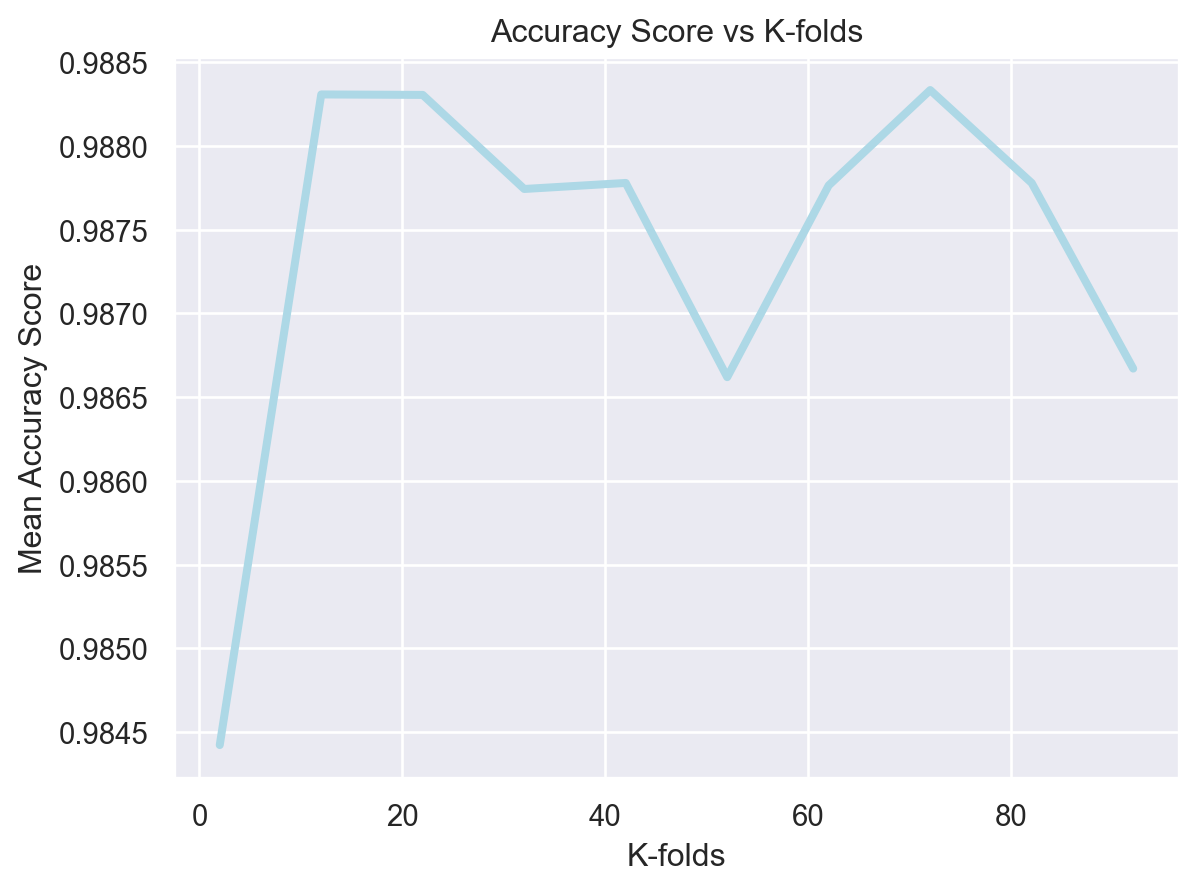

In [7]:
(
    so.Plot(x = k_vals, y = acc_scores)
    .add(so.Line(linewidth = 3, color = 'lightblue'))
    .label(x = 'K-folds', y = 'Mean Accuracy Score', title = 'Accuracy Score vs K-folds')
)


### Summary
---
Mean accuracy score of KN classifier is acheived with ~40 fold cross validation

## Multi-layer perception classifier (feedforwad MLP-NN)

In [8]:
def xval_MLP( layers, activation, data = digits.frame, features = digits.feature_names,
                     target = 'target', k_fold = 4):
    
    kf = KFold(n_splits = k_fold, shuffle= True)
    
    acc_test, acc_train = list(), list()
    
    for train_index, test_index in kf.split(data):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        mlp = MLPClassifier(hidden_layer_sizes=layers, activation=activation).fit(train[features], train[target])
        
        test_prediction = mlp.predict(test[features])
        train_prediction = mlp.predict(train[features])
        
        acc_score_test = accuracy_score(test[target], test_prediction)
        acc_score_train = accuracy_score(train[target], train_prediction)
        acc_test.append(acc_score_test)
        acc_train.append(acc_score_train)
    return (np.mean(acc_score_test), np.mean(acc_score_train))
    
    

In [9]:
neurons = [8,16,32,64,128,256]
mlp_acc = [xval_MLP(layers = (n,), activation = 'relu') for n in neurons]

/Users/michaelschaid/opt/anaconda3/envs/digits/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/michaelschaid/opt/anaconda3/envs/digits/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/michaelschaid/opt/anaconda3/envs/digits/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/michaelschaid/opt/anaconda3/envs/digits/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

In [10]:
(
    so.Plot(x = neurons, y =mlp_acc[0] )
    .add(so.Line(linewidth = 2, color = 'lightblue'))
    .label(x = 'Neurons', y = 'Mean Accuracy Score', title = 'Accuracy Score vs K-folds')
)

ValueError: All arrays must be of the same length

In [11]:
mlp_acc

[(0.910913140311804, 0.973293768545994),
 (0.9599109131403119, 0.9970326409495549),
 (0.9866369710467706, 0.9992581602373887),
 (0.9755011135857461, 1.0),
 (0.9799554565701559, 1.0),
 (0.9821826280623608, 1.0)]